# Model Training
## 1) Import Packages

In [7]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings

## 2) Import CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('../data/stock_data.csv')

### Show Top 5 Records

In [4]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,67.920815,67.920815,66.819638,66.914918,27278000
1,2020-01-03,67.565491,68.172409,66.860816,66.894565,23408000
2,2020-01-06,69.366394,69.391700,67.043446,67.074704,46768000
3,2020-01-07,69.232399,69.648755,69.056232,69.497895,34330000
4,2020-01-08,69.725182,70.063128,69.109336,69.218012,35314000


## 3) Feature Engineering (Making the Data Smart)   

Raw prices (Open, High, Low, Close) are not enough. We need to give the model "Hints" about the trend.

We will create 3 specific hints in the Notebook:
- SMA_10 (Short Term Trend): Average price of the last 10 days.
- SMA_50 (Long Term Trend): Average price of the last 50 days.
- Volatility (Risk): How much the price is shaking up and down.

In [5]:
# Create moving averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Create Volatility (Risk) feature
df['Volatility'] = df['Close'].rolling(window=10).std()

# Create Target variable: Next day price movement
df['Target'] = df['Close'].shift(-1)

# Drop rows with NaN values created by rolling calculations
print("Rows before cleaning :", len(df))
df.dropna(inplace=True)
print("Rows after cleaning  :", len(df))

# show the new columns
df[['Date', 'Close', 'SMA_10', 'SMA_50', 'Volatility', 'Target']].tail()


Rows before cleaning : 1508
Rows after cleaning  : 1458


,Date,Close,SMA_10,SMA_50,Volatility,Target
1502,2025-12-23,314.350006,308.719000,290.253782,6.406795,314.089996
1503,2025-12-24,314.089996,308.107001,291.629791,5.400437,313.510010
1504,2025-12-26,313.510010,308.215002,292.882673,5.506259,313.559998
1505,2025-12-29,313.559998,308.642001,294.127961,5.758666,313.850006
1506,2025-12-30,313.850006,309.205002,295.342272,5.983641,313.000000


## 4) Train-Test Split

In [10]:
# Define features and target
feature_cols = ['Close', 'SMA_10', 'SMA_50', 'Volatility']
target_col = ['Target']

X = df[feature_cols]
Y = df[target_col]

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Total Data : {len(df)} rows")
print(f"Training : {len(X_train)} rows")
print(f"Testing  : {len(X_test)} rows")

print("Shapes......")
print(f"X_train shape : {X_train.shape}")
print(f"Y_train shape : {Y_train.shape}")



Total Data : 1458 rows
Training : 1166 rows
Testing  : 292 rows
Shapes......
X_train shape : (1166, 4)
Y_train shape : (1166, 1)


## 5) Data Preprocessing (Scalling)
Convert all numbers to the same scale (Mean = 0, Deviation = 1)

In [14]:
from sklearn.preprocessing import StandardScaler


# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print ("Feature scaling completed. Sample of scaled features:")
print("Check Mean")
print(X_train_scaled.mean())

Feature scaling completed. Sample of scaled features:
Check Mean
Close        -1.980501e-16
SMA_10       -4.265694e-17
SMA_50        3.854359e-16
Volatility   -9.750158e-17
dtype: float64


## 6) Define Models & Evaluation Metric
Create a Dictionary of algorithms to test which one is best for the stock prediction.

In [24]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}


# The Evaluation function
def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    """
      Trains a model and return its performance metrics
    """
    
    #.values.ravel() converts the column into a flat 1D array
    model.fit(X_train, Y_train.values.ravel())
    
    # Predict on training data
    train_preds = model.predict(X_train)
    mae_train = mean_absolute_error(Y_train, train_preds)
    r2_train = r2_score(Y_train, train_preds)
    
    # Predict on testing data
    test_preds = model.predict(X_test)
    mae_test = mean_absolute_error(Y_test, test_preds)
    r2_test = r2_score(Y_test, test_preds)
    
    
    
    return mae_train, mae_test, r2_train, r2_test


print("Models and Functions Loaded")
    

Models and Functions Loaded


## 7) Train & Compare 
Loop through the list, train each one, and record the score.

In [31]:
results = []

print("Starting model training and evaluation...")

for name, model, in models.items():
    
    # Get both scores
    mae_train, mae_test, r2_train, r2_test = evaluate_model(model, X_train_scaled, Y_train, X_test_scaled, Y_test)

    # Calculate the Overfitting Gap 
    gap = mae_test - mae_train
    
    
    # save result
    results.append({"Model ": name, 
                    "MAE Train": mae_train, 
                    "MAE Test": mae_test,
                    "R2 Train": r2_train,
                    "R2 Test": r2_test,
                    "Gap (Overfitting)": gap})
    
    print(f"{name} ")
    print("Model Performance for Training set")
    print(f"MAE: {mae_train:.2f} | R2: {r2_train:.2f}")
    print("Model Performance for Testing set")  
    print(f"MAE: {mae_test:.2f} | R2: {r2_test:.2f}")
    print(f"Overfitting Gap (Test MAE - Train MAE): {gap:.2f}")
    print('='*35)
    print('\n')
    

print("\n All individual models trained!")

Starting model training and evaluation...
Linear Regression 
Model Performance for Training set
MAE: 1.93 | R2: 1.00
Model Performance for Testing set
MAE: 1.78 | R2: 1.00
Overfitting Gap (Test MAE - Train MAE): -0.15


Ridge Regression 
Model Performance for Training set
MAE: 1.95 | R2: 1.00
Model Performance for Testing set
MAE: 1.79 | R2: 1.00
Overfitting Gap (Test MAE - Train MAE): -0.17


Lasso Regression 
Model Performance for Training set
MAE: 2.08 | R2: 1.00
Model Performance for Testing set
MAE: 1.82 | R2: 1.00
Overfitting Gap (Test MAE - Train MAE): -0.26


Random Forest 
Model Performance for Training set
MAE: 0.77 | R2: 1.00
Model Performance for Testing set
MAE: 2.05 | R2: 1.00
Overfitting Gap (Test MAE - Train MAE): 1.28


AdaBoost 
Model Performance for Training set
MAE: 2.75 | R2: 0.99
Model Performance for Testing set
MAE: 2.96 | R2: 0.99
Overfitting Gap (Test MAE - Train MAE): 0.21


CatBoost 
Model Performance for Training set
MAE: 1.33 | R2: 1.00
Model Performance f

## 8) The Ensemble (The Super Model)
combine the top models into a "voting regressor".

- Linear Regression catches the trend.
- Random Forest catches the volatility.
- XGBoost catches complex patterns.
- Ensemble: Takes the average of all three. It is usually more stable than any single model.

In [50]:
ensemble = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators = 100, random_state = 42)),
    ('xgb', XGBRegressor(n_estimators = 100,learning_rate = 0.1, random_state = 42))
])

# Train the Ensemble model
mae_train, mae_test, r2_train, r2_test = evaluate_model(ensemble, X_train_scaled, Y_train, X_test_scaled, Y_test)

# Calculate the Overfitting Gap 
gap = mae_test - mae_train

# Add to results 
results.append({"Model ": "Ensemble Voting", "MAE Train": mae_train, "MAE Test": mae_test, "R2 Train": r2_train, "R2 Test": r2_test, "Gap (Overfitting)": gap})
print(f"Ensemble Voting - MAE Train: {mae_train:.2f}, MAE Test: {mae_test:.2f}, R2 Train: {r2_train:.2f}, R2 Test: {r2_test:.2f}, Gap: {gap:.2f}")

Ensemble Voting - MAE Train: 1.19, MAE Test: 1.85, R2 Train: 1.00, R2 Test: 1.00, Gap: 0.66


## 9) The Final Leaderboard 
Sort the table and pick the winner.


In [51]:
results_df = pd.DataFrame(results).sort_values(by = "R2 Test", ascending=False)

print("\nModel Performance Summary:")
display(results_df)


winner = results_df.iloc[0]
print(f"\nBest Model: {winner['Model']} with MAE: {winner['MAE Test']:.2f} and R2: {winner['R2 Test']:.2f}")


Model Performance Summary:


,Model,MAE Train,MAE Test,R2 Train,R2 Test,Gap (Overfitting),Model
0,Linear Regression,1.930164,1.784885,0.996732,0.997504,-0.145279,NaN
1,Ridge Regression,1.952623,1.785381,0.996679,0.997392,-0.167242,NaN
2,Lasso Regression,2.079449,1.818987,0.996305,0.997341,-0.260462,NaN
9,Ensemble Voting,1.188591,1.846013,0.998859,0.997226,0.657421,NaN
8,NaN,1.188591,1.846013,0.998859,0.997226,0.657421,Ensemble Voting
7,NaN,1.188591,1.846013,0.998859,0.997226,0.657421,Ensemble Voting
3,Random Forest,0.768724,2.052769,0.999500,0.996749,1.284045,NaN
5,CatBoost,1.331826,2.060828,0.998743,0.996365,0.729002,NaN
6,XGBoost,0.460573,2.252561,0.999837,0.995727,1.791987,NaN
4,AdaBoost,2.749716,2.958279,0.994704,0.993583,0.208563,NaN



Best Model: nan with MAE: 1.78 and R2: 1.00


### Linear Regression

In [ ]:
lin_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators = 100, random_state = 42)),
    ('xgb', XGBRegressor(n_estimators = 100,learning_rate = 0.1, random_state = 42))
])
lin_model = lin_model.fit(X_train_scaled, Y_train.values.ravel())
y_pred = lin_model.predict(X_test_scaled)
score = r2_score(Y_test, y_pred)*100
print(f"R2 Score for voting regressor: {score:.2f}%")



R2 Score for Linear Regression: 99.72%


Plot y_pred and y_test 

Text(0, 0.5, 'Predicted Prices')

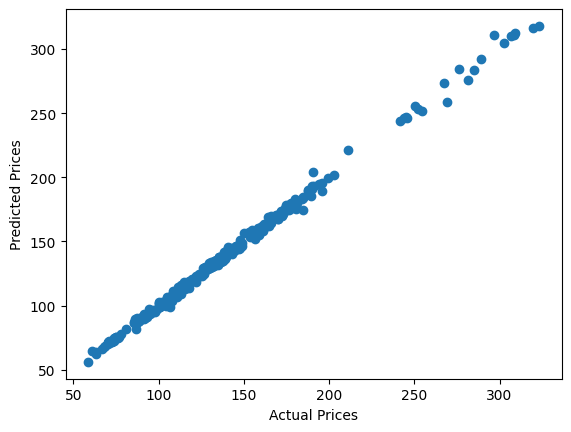

In [47]:
plt.scatter(Y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

<Axes: >

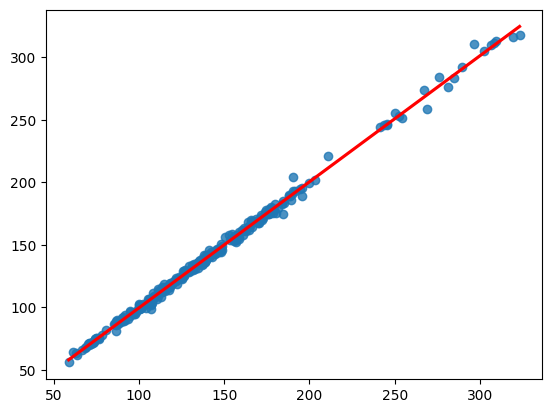

In [49]:
sns.regplot(x=Y_test.values.ravel(), y=y_pred, ci = None, line_kws={"color": "red"})